In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.9 MB/s 
     |████████████████████████████████| 182 kB 15.5 MB/s 
     |████████████████████████████████| 7.6 MB 51.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('drive/MyDrive/Dataset/StanceDataset/train.csv', encoding='latin-1', engine='python')
df_train

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,"There's a law protecting unborn eagles, but no...",Legalization of Abortion,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2910,I am 1 in 3... I have had an abortion #Abortio...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,other
2911,How dare you say my sexual preference is a cho...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2912,"Equal rights for those 'born that way', no rig...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [ ]:
df_test = pd.read_csv('drive/MyDrive/Dataset/StanceDataset/test.csv', encoding='latin-1', engine='python')
df_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [ ]:
df_train['Stance'].value_counts()

AGAINST    1395
NONE        766
FAVOR       753
Name: Stance, dtype: int64

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    # return re.sub(emoji.emoji_list(), r"", text) #remove emoji
    # rem = clean(text, no_emoji=True)
    # return rem
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
X_train, X_val = train_test_split(df_train, test_size=0.1)

In [ ]:
df_train = X_train[['Tweet', 'Stance']]
df_test = df_test[['Tweet', 'Stance']]
df_val = X_val[['Tweet', 'Stance']]

In [ ]:
texts_new = []
for t in df_train['Tweet']:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
texts_new_test = []
for t in df_test['Tweet']:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
texts_new_val = []
for t in df_val['Tweet']:
    texts_new_val.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [ ]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test
df_val['text_clean'] = texts_new_val

<ipython-input-13-663faa2c4f23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text_clean'] = texts_new
<ipython-input-13-663faa2c4f23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['text_clean'] = texts_new_val


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df_train['Stance'] = df_train['Stance'].map({'AGAINST':-1, 'NONE':0, 'FAVOR':1})
df_test['Stance'] = df_test['Stance'].map({'AGAINST':-1, 'NONE':0, 'FAVOR':1})
df_val['Stance'] = df_val['Stance'].map({'AGAINST':-1, 'NONE':0, 'FAVOR':1})

<ipython-input-15-cbcd39e4da39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Stance'] = df_train['Stance'].map({'AGAINST':-1, 'NONE':0, 'FAVOR':1})
<ipython-input-15-cbcd39e4da39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['Stance'] = df_val['Stance'].map({'AGAINST':-1, 'NONE':0, 'FAVOR':1})


In [ ]:
df_train['Stance'].value_counts()

-1    1258
 0     692
 1     672
Name: Stance, dtype: int64

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['Stance']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Stance']);

In [ ]:
train_os['Stance'].value_counts()

-1    1258
 1    1258
 0    1258
Name: Stance, dtype: int64

In [ ]:
x_train = train_os['text_clean'].values
y_train = train_os['Stance'].values
x_test = df_test['text_clean'].values
y_test = df_test['Stance'].values
x_val = df_val['text_clean'].values
y_val = df_val['Stance'].values

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(x_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(x_test, MAX_LEN)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_val), epochs=2, batch_size=64)

Epoch 1/2
59/59 [==============================] - 108s 2s/step - loss: 1.0691 - categorical_accuracy: 0.4277 - val_loss: 0.9914 - val_categorical_accuracy: 0.5240
Epoch 2/2
59/59 [==============================] - 91s 2s/step - loss: 0.8936 - categorical_accuracy: 0.5890 - val_loss: 0.8158 - val_categorical_accuracy: 0.6199


In [ ]:
result_bert = model.predict([test_input_ids, test_attention_masks])

62/62 [==============================] - 22s 274ms/step


In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

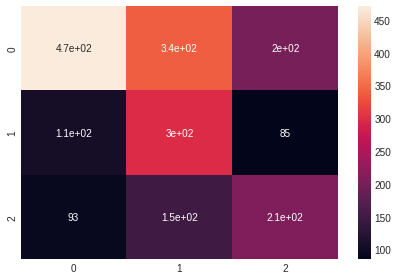

In [ ]:
cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))
sns.heatmap(cm, annot=True)


In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['AGAINST', 'NONE', 'FAVOR']))

	Classification Report for BERT:

               precision    recall  f1-score   support

     AGAINST       0.70      0.46      0.56      1014
        NONE       0.38      0.61      0.47       490
       FAVOR       0.42      0.46      0.44       452

   micro avg       0.50      0.50      0.50      1956
   macro avg       0.50      0.51      0.49      1956
weighted avg       0.56      0.50      0.51      1956
 samples avg       0.50      0.50      0.50      1956



In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(x_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(x_test, MAX_LEN)

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=2, batch_size=64)

Epoch 1/2
59/59 [==============================] - 113s 2s/step - loss: 1.0986 - categorical_accuracy: 0.3771 - val_loss: 1.0476 - val_categorical_accuracy: 0.4692
Epoch 2/2
59/59 [==============================] - 91s 2s/step - loss: 0.8625 - categorical_accuracy: 0.6078 - val_loss: 0.8080 - val_categorical_accuracy: 0.6575


In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

62/62 [==============================] - 19s 257ms/step


In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

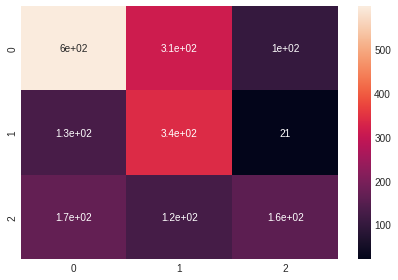

In [ ]:
cm = confusion_matrix(y_test.argmax(1), y_pred_roberta.argmax(1))
sns.heatmap(cm, annot=True)

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.67      0.59      0.63      1014
     Neutral       0.44      0.69      0.54       490
    Positive       0.56      0.35      0.43       452

   micro avg       0.56      0.56      0.56      1956
   macro avg       0.55      0.54      0.53      1956
weighted avg       0.58      0.56      0.56      1956
 samples avg       0.56      0.56      0.56      1956

